# Part 3 (a) (Continued..)

Plan of action:

- Preprocess the data, using `load_and_preprocess`, and split the data into `train_texts`, `val_texts` and `val_text_70` $\equiv$ 900, 100 and 100 (systems). 
- The two validation sets `val_texts` and `val_text_70` have the same `shape` but:
    - In `val_texts` each system has the full 100 pairs of prey and predators
    - In `val_texts_70` each system has only the first 70 pairs of prey and predators
- We train the model on tokenised `train_texts`
- We validated the model by predicting the remaining 30 pair points in each of the 100 system in tokenised `val_texts_70`. 
- We then compare the predicted results from `val_texts_70` to the gruond truth data `val_texts` (or `true_val_values` obtained with `data_scale_split`)
- Just like for the untrained models we then want to compute MSE and RMSE 
- And report the loss/perplexity of each trained models

We are recomended to train our model up to 10,000 steps, but we have a budgeted number of flops overall for training $10^{17}$ and due to computational power required, we are going to proceed with fewer steps first, also to familiarise with the traing procedure, before increasing the number of steps and using HPC.

ESSENTIALLY

“We trained on 900 systems, validated on 100 full sequences for loss monitoring, and evaluated forecasting performance by generating future predictions given the first 70 steps from each validation sequence.”

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessor import*
from src.plotting import*
from sklearn.metrics import mean_absolute_error
from src.minimal_lora_eval import process_sequences
from src.qwen import tokenize_time_series_np
from src.minimal_lora_eval import evaluate_loss, process_sequences

In [2]:
import torch
# Set seed
torch.manual_seed(23)

In [ ]:
from src.minimal_lora_eval import model, tokenizer # Import model and tokenizer from qwen with lora injected

2025-03-28 15:36:09.376811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743176169.393665   52044 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743176169.398643   52044 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-28 15:36:09.423400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [ ]:
train_texts, val_texts, val_texts_70 = load_and_preprocess("data/lotka_volterra_data.h5") # preprocess the data

# split the data not converting to string, this will be used to compute the error in the validation set
_, true_val_values, _ = data_scale_split("data/lotka_volterra_data.h5") 

Tokenise with overlapping chucks

In [ ]:
""" 
Here we are:
1. Tokenising each time series using Qwen tokenizer
2. Chunking the tokenised output into sliding windows of tokens (for training)
3. Pad shorter sequences to a fixed length
"""

train_input_ids = process_sequences(train_texts, tokenizer, max_length=512, stride=256)
val_input_ids = process_sequences(val_texts, tokenizer, max_length=512, stride=512)

The reason why we stride our training dataset, is to generate more overlap during training, wich leads to more signal from each long sequence

Train the Model

In [ ]:
# TensorDataset allows you to wrap tensors into a dataset object
# DataLoader provides minibatch iteration over the dataset
from torch.utils.data import TensorDataset, DataLoader

# Accelerator from Hugging Face simplifies GPU/multi-device/mixed-precision training
from accelerate import Accelerator

# tqdm is used for progress bars — makes training loops easier to monitor
from tqdm import tqdm


In [ ]:
# Set hyperparameters
batch_size = 4  # Number of sequences per training batch
learning_rate = 1e-5 # Learning rate for the optimizer

# Set up the optimizer to update only trainable parameters (e.g., LoRA adapters + LM head bias)
optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=learning_rate
)
# Wrap the training data into a TensorDataset and DataLoader for batching
train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize Hugging Face Accelerator for device/mixed-precision handling
accelerator = Accelerator()

# Prepare model, optimizer, and dataloader with Accelerator
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

In [ ]:


# Set model to training mode
model.train()
steps = 0

max_steps = 5000
# Start training loop
while steps < max_steps:  # QPLPPP = 10,000 steps
    for (batch,) in tqdm(train_loader, desc=f"Steps {steps}"):

         # Reset gradients
        optimizer.zero_grad()

        # Forward pass with labels = input_ids for language modeling (next-token prediction)
        outputs = model(batch, labels=batch)
        loss = outputs.loss

        # Backpropagation using Accelerator
        accelerator.backward(loss)
        optimizer.step()

        # Step counter
        steps += 1

        # Break loop after desired number of steps
        if steps >= max_steps:
            break

Steps 0:   3%|▎         | 31/1142 [07:25<4:25:48, 14.36s/it]


KeyboardInterrupt: 

Computing validation loss before prediction

In [85]:
val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=4)
val_loader = accelerator.prepare(val_loader)

val_loss = evaluate_loss(model, val_loader, accelerator)
print(f"Validation Loss: {val_loss:.4f}")


Validating: 100%|██████████| 75/75 [04:14<00:00,  3.39s/it, avg_loss=2.6149]

Validation Loss: 2.6149


Collecting loss and perplexity

In [ ]:
print(f"After training with {max_steps} steps")
print(f"Training loss: {loss.item():.4f}")
perplexity = torch.exp(loss).item()
print(f"Perplexity: {perplexity:.2f}")


Training loss: 3.3369
Perplexity: 28.13


In [39]:
def sequence_length_array(tokenized_string):

    
    max_lengths = np.array([entry["input_ids"].shape[1] for entry in tokenized_string])
    return max_lengths

In [ ]:
# Tokeniseing data series
tok_val_texts = tokenize_time_series_np(val_texts)
tok_val_texts_70 = tokenize_time_series_np(val_texts_70)


Now that the model is trained and validated we can perform prdictions using `model.generate()`

In [93]:
# Unwrap the model from Accelerate (optional) and move to GPU
model = accelerator.unwrap_model(model)
model.to("cuda")
model.eval()

predictions_encoded = []

# Loop over each validation sample for generation
for i in tqdm(range(len(tok_val_texts_70)), desc="Generating predictions"):
    
    # Extract tokenized input and attention mask for system i
    input_ids = tok_val_texts_70[i]["input_ids"].to(model.device)
    attention_mask = tok_val_texts_70[i]["attention_mask"].to(model.device)

    # Use model.generate() to predict the next tokens
    output = model.generate(
        input_ids=input_ids,                 # Input sequence (first 70 timesteps)
        attention_mask=attention_mask,       # Mask to ignore padding tokens
        min_new_tokens=225,                   # Force at least 30 new tokens to be generated
        max_new_tokens=250,                   # Upper bound to avoid runaway generation
        do_sample=False,                     # Use deterministic decoding (greedy search)
        eos_token_id=tokenizer.eos_token_id  # Stop generation at EOS if it appears
    )

    # Append generated output to the list (will decode later)
    predictions_encoded.append(output)


Generating predictions:   1%|          | 1/100 [01:01<1:41:37, 61.59s/it]


KeyboardInterrupt: 

Skipping invalid entry: 22.000,4.260]
```

I have tried to use the `scipy.optimize.minimize` function with a custom objective function that takes → could not convert string to float: '4.260]\n```\n\nI have tried to use the `scipy.optimize.minimize` function with a custom objective function that takes'


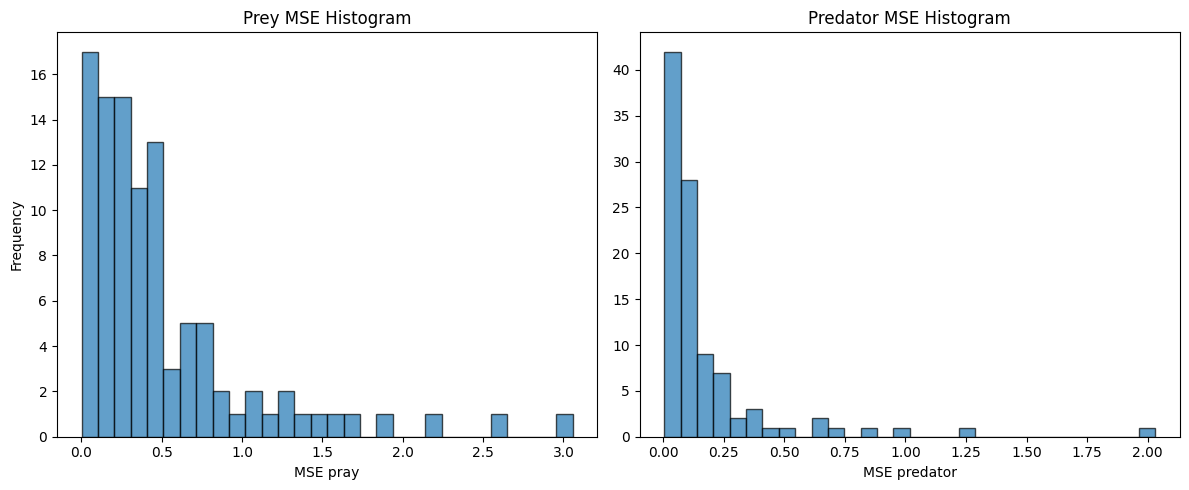

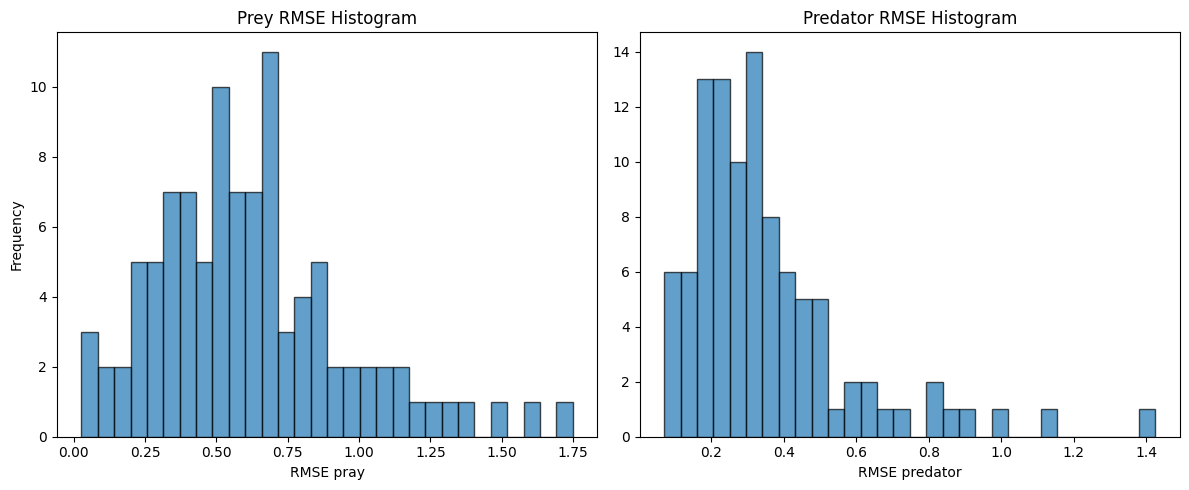

Decoded prediction shape: (74, 2)
True dataset shape: (100, 2)


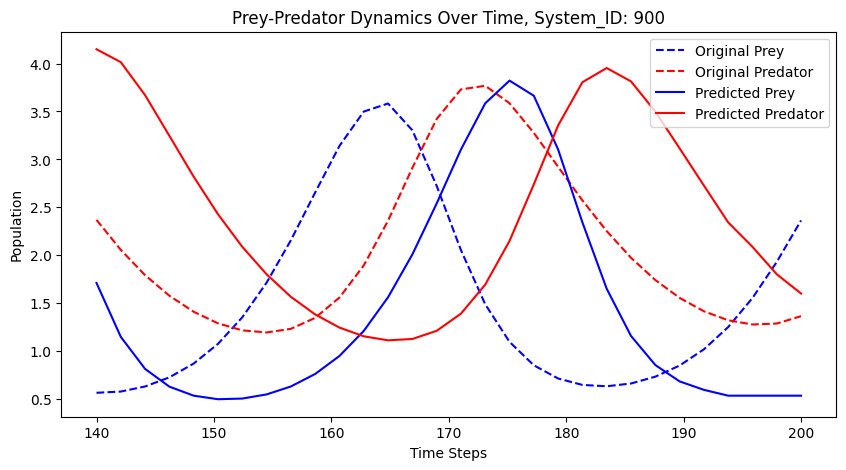

In [88]:
predictions_decoded = []

for i in range(len(tok_val_texts_70)):
    decoded_output = string_to_array(tokenizer.decode(predictions_encoded[i][0], skip_special_tokens=True))
    predictions_decoded.append(decoded_output)

predicted_output = []
true_values = []
# Collecting the last 30 pair from each array
for i in range(len(predictions_decoded)):
    sub_output = predictions_decoded[i]
    sub_output_min_30 = sub_output[70:]
    true_v = true_val_values[i]
    true_v_min_30 = true_v[70:]
    predicted_output.append(sub_output_min_30)
    true_values.append(true_v_min_30)

# Computing MSE
MSE_values = []

for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output[i]), len(true_values[i]))
    pr_out = predicted_output[i][:min_length]
    true_val = true_values[i][:min_length]

    # Compute the MSE
    mse_prey = mean_absolute_error(pr_out[:,0], true_val[:,0]) # Computing MSE for prey
    mse_predator = mean_absolute_error(pr_out[:,1], true_val[:,1]) # Computing MSE for predator
    MSE_values.append([mse_prey, mse_predator])

# Computing RMSE
RMSE_values = np.sqrt(MSE_values)

df_MSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values)),  
    "MSE for prey": np.array(MSE_values)[:, 0],  # Flatten prey values
    "MSE for predator": np.array(MSE_values)[:, 1]  # Flatten predator values
})
df_RMSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values)),  
    "RMSE for prey": RMSE_values[:, 0],  # Flatten prey values
    "RMSE for predator": RMSE_values[:, 1]  # Flatten predator values
})

from src.plotting import PlotProject
PlotProject.plot_hist_MSE(df_MSE_values,bins=30) # Plotting MSE distribution
PlotProject.plot_hist_RMSE(df_RMSE_values,bins=30) # Plotting RMSE distribution
pred_vs_true_visualisation(predictions_decoded, true_val_values, 0)

Decoded prediction shape: (74, 2)
True dataset shape: (100, 2)


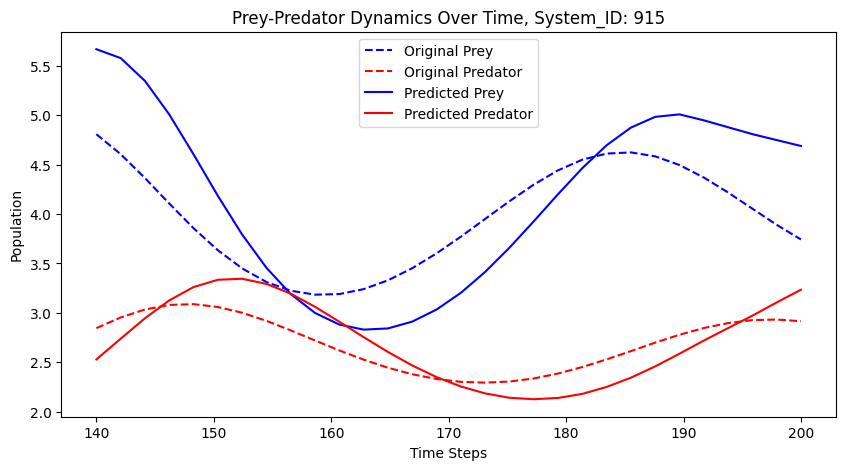

Decoded prediction shape: (74, 2)
True dataset shape: (100, 2)


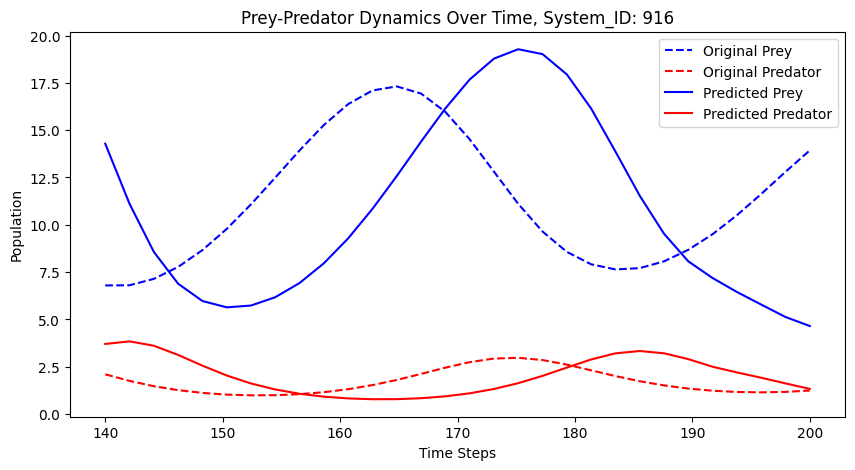

Decoded prediction shape: (74, 2)
True dataset shape: (100, 2)


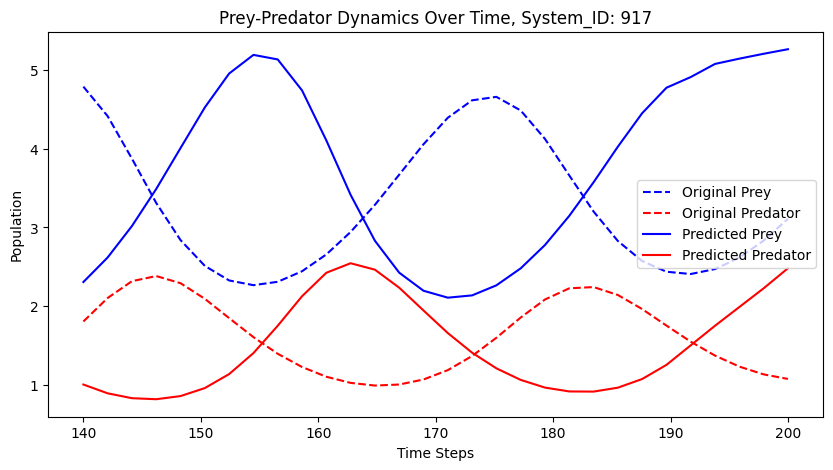

Decoded prediction shape: (74, 2)
True dataset shape: (100, 2)


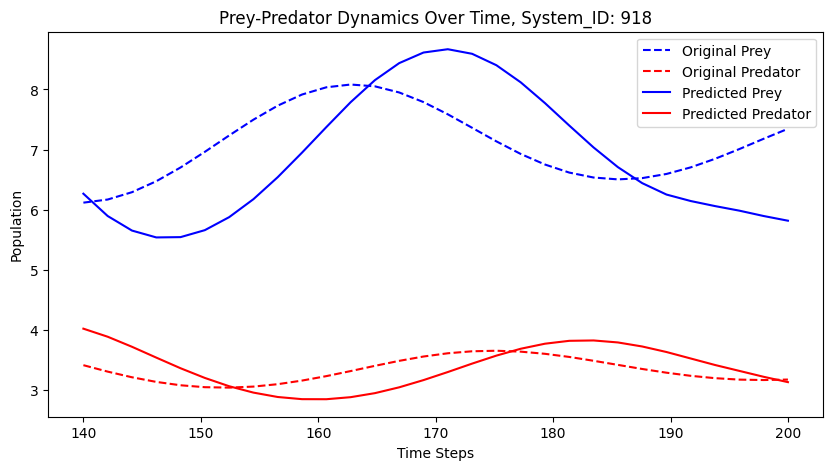

Decoded prediction shape: (74, 2)
True dataset shape: (100, 2)


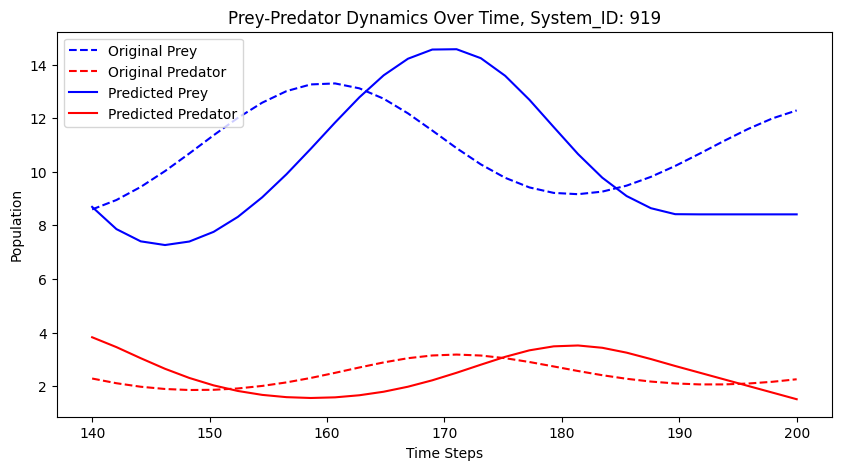

In [91]:
for i in range(15,20): 
    pred_vs_true_visualisation(predictions_decoded, true_val_values, i)